#  Random Forest Closed & Open world experiment


## 1. Data Download and Feature Extraction Tools


In [ ]:
# Import
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import gdown
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, balanced_accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier


# ============================================
# 0) Data Auto Download Setup
# ============================================

FILE_IDS = {
    "mon_standard.pkl": "1JN3QzG5pJ7TEapZGa7zsQvOM5suvkD63",
    "unmon_standard10.pkl": "1CiAzI-GeRrLhr5Vebdyxb3-4BX9g35rn",
}

# Check gdown installation
try:
    gdown.download_folder
except AttributeError:
    !pip install gdown

# Automatically downloads data using Google Drive File IDs to the local environment.
def download_data_for_colab():
    for filename, file_id in FILE_IDS.items():
        filepath = f'/content/{filename}'
        if not os.path.exists(filepath):
            # Execute gdown
            !gdown --id $file_id -O $filepath --fuzzy

# Set seed for reproducibility to ensure consistent results.
SEED = 42
np.random.seed(SEED)


# ============================================
# 1) ~ 4) Utility and Feature Extraction Functions
# ============================================

# Calculates traffic bursts (sum of packet sizes until direction change) from a sequence of packet sizes.
def compute_bursts(size_seq):
    if len(size_seq) == 0:
        return []
    bursts = []
    current_sign = np.sign(size_seq[0])
    current_sum = size_seq[0]
    for s in size_seq[1:]:
        sign = np.sign(s)
        if sign == current_sign:
            current_sum += s
        else:
            bursts.append(current_sum)
            current_sum = s
            current_sign = sign
    bursts.append(current_sum)
    return bursts


# Counts the number of times the sign changes (zero crossings) in a cumulative flow sequence.
def compute_zero_crossings(arr):
    if len(arr) == 0:
        return 0
    sgn = np.sign(arr)
    for i in range(len(sgn)):
        if sgn[i] == 0:
            sgn[i] = sgn[i-1] if i > 0 else 0
    changes = np.diff(sgn)
    return np.sum(changes != 0)


# Extracts 20 statistical features (volume, timing, cumulative flow, etc.) from a single traffic trace.
def extract_features_one_trace(times, sizes, initial_k=30):
    times = np.array(times)
    sizes = np.array(sizes)
    n_packets = len(sizes)
    if n_packets == 0:
        return {
            "n_total": 0, "n_out": 0, "n_in": 0, "ratio_out_in": 0.0, "frac_out": 0.0,
            "mean_inter_time": 0.0, "std_inter_time": 0.0, "min_inter_time": 0.0, "max_inter_time": 0.0,
            "n_bursts": 0, "mean_burst_interval": 0.0, "initial_n_out": 0, "initial_n_in": 0,
            "initial_mean_inter_time": 0.0, "initial_std_inter_time": 0.0,
            "cum_final": 0.0, "cum_abs_sum": 0.0, "cum_max_abs": 0.0, "cum_zero_crossings": 0
        }

    n_out = np.sum(sizes > 0); n_in = np.sum(sizes < 0); ratio_out_in = n_out / max(n_in, 1); frac_out = n_out / n_packets
    if len(times) >= 2:
        inter_times = np.diff(times)
        mean_inter_time = float(np.mean(inter_times)); std_inter_time = float(np.std(inter_times)); min_inter_time = float(np.min(inter_times)); max_inter_time = float(np.max(inter_times))
    else:
        mean_inter_time = std_inter_time = min_inter_time = max_inter_time = 0.0

    bursts = compute_bursts(sizes); n_bursts = len(bursts); mean_burst_interval = 0.0
    if n_bursts >= 2:
        burst_starts = [0]; cur_sign = np.sign(sizes[0])
        for i in range(1, n_packets):
            if np.sign(sizes[i]) != cur_sign: burst_starts.append(i); cur_sign = np.sign(sizes[i])
        burst_times = times[burst_starts]
        if len(burst_times) >= 2: mean_burst_interval = float(np.mean(np.diff(burst_times)))

    k = min(initial_k, n_packets); sizes_init = sizes[:k]; times_init = times[:k]
    initial_n_out = int(np.sum(sizes_init > 0)); initial_n_in = int(np.sum(sizes_init < 0))

    if k >= 2:
        inter_times_init = np.diff(times_init)
        initial_mean_inter_time = float(np.mean(inter_times_init)); initial_std_inter_time = float(np.std(inter_times_init))
    else: initial_mean_inter_time = 0.0; initial_std_inter_time = 0.0
    cum_sizes = np.cumsum(sizes)

    return {
        "n_total": int(n_packets), "n_out": int(n_out), "n_in": int(n_in), "ratio_out_in": float(ratio_out_in), "frac_out": float(frac_out),
        "mean_inter_time": mean_inter_time, "std_inter_time": std_inter_time, "min_inter_time": min_inter_time, "max_inter_time": max_inter_time,
        "n_bursts": int(n_bursts), "mean_burst_interval": mean_burst_interval, "initial_n_out": initial_n_out, "initial_n_in": initial_n_in,
        "initial_mean_inter_time": initial_mean_inter_time, "initial_std_inter_time": initial_std_inter_time,
        "cum_final": float(cum_sizes[-1]), "cum_abs_sum": float(np.sum(np.abs(cum_sizes))),
        "cum_max_abs": float(np.max(np.abs(cum_sizes))), "cum_zero_crossings": compute_zero_crossings(cum_sizes),
    }


# Aggregates extracted features from multiple traces into a final Pandas DataFrame.
def build_feature_dataframe(X1, X2):
    rows = []
    for t, s in zip(X1, X2): rows.append(extract_features_one_trace(t, s))
    return pd.DataFrame(rows)


# Visualizes the Confusion Matrix based on model predictions and true labels.
def plot_confusion_matrix(y_test, y_pred, title_prefix, labels=['Unmonitored (0)', 'Monitored (1)']):
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    plt.title(f"{title_prefix} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    tn, fp, fn, tp = cm.ravel()
    plt.text(0.5, 1.05, f"TP (Correct Detection): {tp} | FP (False Positive): {fp}", transform=ax.transAxes, fontsize=10, color='darkgreen', ha='center')
    plt.text(0.5, 1.01, f"FN (False Negative): {fn} | TN (Correct Rejection): {tn}", transform=ax.transAxes, fontsize=10, color='darkred', ha='center')

    plt.grid(False)
    plt.show()

# Calculates and visualizes the ROC Curve and the Precision-Recall Curve.
def plot_curves(y_test, y_score, title_prefix):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label='ROC')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} ROC Curve")
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(rec, prec, label='PR Curve')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.grid(True)
    plt.show()

# 2. Data Preprocessing and Feature Extraction


In [ ]:
# ============================================
# 5) Data Loading and Preprocessing Functions
# ============================================

# Displays a preview of the top 5 samples in a Pandas DataFrame format.
def show_sequence_preview(X1_seq, X2_seq, y_labels=None, title=""):
    # Output: Top 5 Preview (DataFrame)
    print(f"\nTop 5 Preview: {title}")
    rows = []

    num_samples = len(y_labels) if y_labels is not None else len(X1_seq)

    for i in range(min(5, num_samples)):
        row = {
            "index": i,
            "len_X1": len(X1_seq[i]),
            "len_X2": len(X2_seq[i]),
            "X1_head": X1_seq[i][:10],
            "X2_head": X2_seq[i][:10]
        }
        if y_labels is not None:
            row["label"] = y_labels[i]
        rows.append(row)

    print(pd.DataFrame(rows))

# Loads PKL data, performs packet sequence conversion, and applies URL sampling.
def load_and_preprocess_data(
    file_path: str, max_len: int, total_urls: int, is_monitored: bool,
    url_per_site: int = 10, use_sublabel: bool = False, sample_size: int = None
):
    print(f"\nLoading {file_path}...")
    with open(file_path, 'rb') as f: data = pickle.load(f)

    X1_seq, X2_seq, y_labels = [], [], []
    indices = range(total_urls)

    is_sampling = (not is_monitored and sample_size is not None) or \
                  (is_monitored and sample_size is not None and total_urls > sample_size)

    if is_sampling:
        if total_urls < sample_size: sample_size = total_urls
        indices = np.random.choice(total_urls, sample_size, replace=False)
        data = [data[i] for i in indices]; indices = range(sample_size)
        # Output: Sampling information
        print(f"Sampling: {total_urls} URLs down to {sample_size} URLs selected.")

    for i in indices:
        if is_monitored: label = i if use_sublabel else i // url_per_site; samples = data[i]
        else: label = -1; samples = [data[i]]

        for sample in samples:
            size_seq = []; time_seq = []
            for c in sample[:max_len]:
                dr = 1 if c > 0 else -1; time_seq.append(abs(c)); size_seq.append(dr * 512)
            X1_seq.append(time_seq); X2_seq.append(size_seq)
            if is_monitored: y_labels.append(label)

    total_samples = len(X1_seq)
    # Output: Total samples processed
    print(f'Total samples processed: {total_samples}')

    if is_monitored:
        show_sequence_preview(X1_seq, X2_seq, np.array(y_labels), title=file_path.split('/')[-1])
    else:
        show_sequence_preview(X1_seq, X2_seq, title=file_path.split('/')[-1])

    return X1_seq, X2_seq, np.array(y_labels)

# ============================================
# Main Execution Logic: Data Loading and Feature Extraction
# ============================================

# --- Configuration Variables ---
MON_FILE = '/content/mon_standard.pkl'; TOTAL_URLS_MON = 950; MAX_LEN_MON = 1500; URL_PER_SITE = 10
MON_URL_SAMPLE_FOR_CW = TOTAL_URLS_MON // 5
MON_KEEP = 100
UNMON_FILE = '/content/unmon_standard10.pkl'; TOTAL_URLS_UNMON = 10000; MAX_LEN_UNMON = 2000; SAMPLE_SIZE_UNMON = 10000

start_total = time.time()

# Executes data download (if necessary)
download_data_for_colab()
print("-" * 50)
print(f"Starting total execution time measurement. Start Time: {time.ctime()}")
print("-" * 50)

# Monitored data processing
X1_mon, X2_mon, y_mon = load_and_preprocess_data(
    file_path=MON_FILE, max_len=MAX_LEN_MON, total_urls=TOTAL_URLS_MON, is_monitored=True,
    url_per_site=URL_PER_SITE, sample_size=MON_URL_SAMPLE_FOR_CW
)
mon_features = build_feature_dataframe(X1_mon, X2_mon)
# Output: Monitored feature head
print("\nMonitored Features (Top 5 Rows):")
print(mon_features.head())

# Unmonitored data processing
X1_unmon, X2_unmon, _ = load_and_preprocess_data(
    file_path=UNMON_FILE, max_len=MAX_LEN_UNMON, total_urls=TOTAL_URLS_UNMON,
    is_monitored=False, sample_size=SAMPLE_SIZE_UNMON
)
unmon_features = build_feature_dataframe(X1_unmon, X2_unmon)
# Output: Unmonitored feature head
print("\nUnmonitored Features (Top 5 Rows):")
print(unmon_features.head())

--------------------------------------------------
Starting total execution time measurement. Start Time: Sun Nov 30 14:13:42 2025
--------------------------------------------------

Loading /content/mon_standard.pkl...
Sampling: 950 URLs down to 190 URLs selected.
Total samples processed: 3800

Top 5 Preview: mon_standard.pkl
   index  len_X1  len_X2                                            X1_head  \
0      0    1500    1500  [0.0, 0.13, 0.13, 0.3, 0.66, 0.93, 0.93, 0.93,...   
1      1    1500    1500  [0.0, 0.17, 0.17, 0.38, 0.38, 1.79, 1.8, 1.8, ...   
2      2    1500    1500  [0.0, 0.14, 0.14, 0.37, 1.83, 2.1, 2.1, 2.1, 2...   
3      3    1500    1500  [0.0, 0.16, 0.16, 0.34, 0.52, 0.71, 0.71, 0.71...   
4      4    1500    1500  [0.0, 0.12, 0.13, 0.27, 0.9, 1.04, 1.04, 1.04,...   

                                             X2_head  label  
0  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  
1  [-512, -512, 512, -512, 512, -512, 512, 512, -...      0  
2  [-512, 

# 3. Closed-world Experiment

**Scenario Goal**: To evaluate the Multi-class Classification capability of an attacker in identifying exactly which of the 95 monitored websites a user is accessing.

**Hyperparameter Tuning Strategy:**

* **Coarse-to-Fine Strategy**: Broad search space (tree count, depth, etc.) is initially screened using RandomizedSearchCV, followed by GridSearchCV for precise exploration around the optimal values to maximize performance.

* **Optimal Parameter Goal**: To secure model stability by reducing variance by adjusting tree diversity (n_estimators, max_features) and complexity (max_depth).

**Tuning Results**:
* n_estimators=500, max_features='log2', and max_depth=None were selected.

**Evaluation Metrics Selection**:

* Accuracy: Measures the prediction of the single correct website.

* Top-3 Accuracy: Evaluates if the model can present a probable group of websites (containing the correct answer) with high confidence, even with low single Accuracy.

**Evaluation Results**:

* Accuracy: 0.5539

* Top-3 Accuracy: 0.7724

**Result Analysis**:

* Classification accuracy for 95 sites is 55.39%, showing some limitation in perfect distinction.

* Top-3 accuracy significantly increased to 77.24%, demonstrating the model can effectively narrow down the candidate pool of targets.



In [ ]:
print("=== [Phase 1] Closed-World Tuning ===")

# 1. Data Splitting (Stratified 80:20)
X_train, X_test, y_train, y_test = train_test_split(
    mon_features.values, y_mon, test_size=0.2, random_state=RANDOM_SEED, stratify=y_mon
)

# --- (1) Baseline ---
rf_base = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)
rf_base.fit(X_train, y_train)
base_acc = accuracy_score(y_test, rf_base.predict(X_test))
print(f" Baseline Accuracy: {base_acc:.4f}")

# --- (2) RandomizedSearchCV (Broad Search) ---
random_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\n Phase 1 Tuning: RandomizedSearchCV in progress...")
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    param_distributions=random_grid,
    n_iter=15, # Number of iterations
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    verbose=1,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)
best_random_params = rf_random.best_params_
print(f"   Best Params (Random): {best_random_params}")

# --- (3) GridSearchCV (Fine Tuning) ---
# Narrowing down the range based on RandomizedSearch results
print("\n Phase 2 Tuning: GridSearchCV in progress...")
best_n = best_random_params['n_estimators']
best_d = best_random_params['max_depth']

param_grid = {
    'n_estimators': [best_n - 50, best_n, best_n + 50],
    'max_depth': [best_d] if best_d is None else [best_d],
    'min_samples_split': [best_random_params['min_samples_split']],
    'max_features': [best_random_params['max_features']]
}
# Prevent negative values
param_grid['n_estimators'] = [n for n in param_grid['n_estimators'] if n > 0]

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
best_params_final = rf_grid.best_params_

# --- (4) Save Results ---
with open(RESULT_FILE, "w") as f:
    import json
    json.dump(best_params_final, f, indent=4)
print(f" Final Best Params: {best_params_final}")
print(f" Parameters saved to {RESULT_FILE}.")

# --- (5) Final Evaluation ---
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, y_proba, k=3)

print(f"\n [Closed-World Result]")
print(f"   - Accuracy: {acc:.4f}")
print(f"   - Top-3 Accuracy: {top3_acc:.4f}")

# --- (6) Additional Evaluation Metrics (Classification Report) ---
print("\n[Closed-World Classification Report]")
print(classification_report(y_test, y_pred))

=== [Phase 1] Closed-World Tuning ===
 Baseline Accuracy: 0.5368

 Phase 1 Tuning: RandomizedSearchCV in progress...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
   Best Params (Random): {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}

 Phase 2 Tuning: GridSearchCV in progress...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Final Best Params: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}
 Parameters saved to rf_tuning_result.json.

 [Closed-World Result]
   - Accuracy: 0.5539
   - Top-3 Accuracy: 0.7724

[Closed-World Classification Report]
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        40
           1       0.56      0.55      0.56        40
           2       0.62      0.62      0.62        40
           3       0.55      0.57      0.56        40
           4       0.74      0.78      0.76        40
           5       0.50      0.50      0.50        40
           6       0.59      0.65      0.62        40
           7       0.61      0.55      0.58        40
           8       0.61      0.55      0.58        40
           9       0.49      0.45      0.47        40
          10       0.39      0.40      0.40        40
          11       0.56      0.57      0.57        40
          12       0.45      0.5

# 3. Feature Importance Analysis (Closed-World)

**Top Features**:

* cum_abs_sum (Cumulative absolute sum of total data transferred volume)

* n_bursts (Number of bursts/changes in packet direction)

* mean_inter_time, mean_burst_interval, max_inter_time (Timing features).

**Interpretation**: The website's unique total content volume (Volume), along with server-client interaction patterns and communication structure, are used as crucial identification evidence.

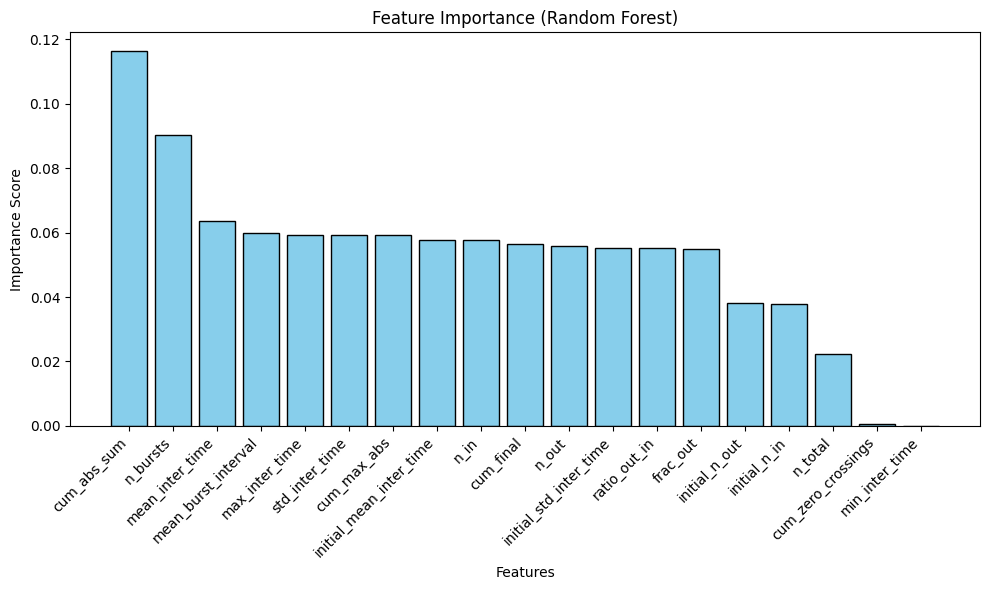

In [ ]:
# Visualize Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))

plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances)), importances[indices], align="center", color='skyblue', edgecolor='black')
plt.xticks(range(len(importances)), [FEATURE_NAMES[i] for i in indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# 4. Open-World Experiment 1 (Binary Classification)

**Scenario Setup & Data Handling**

* Scenario Setup: Performs a Binary Classification task to distinguish between Monitored and Unmonitored traffic, mimicking a real-world environment.

* Imbalanced Data Handling Design: Applied inverse weighting via class_weight='balanced' to prevent bias toward the majority class (unmonitored). This strengthens the learning of the minority class (monitored).


**Evaluation Metrics Selection**:

* Precision, Recall, F1-score: Used as fundamental metrics considering imbalance and threshold sensitivity.

* ROC-AUC: Summarizes the overall discriminative power.

* TPR at 1% FPR: Evaluates real-world attack reliability and the risk of False Positives.

**Evaluation Results**:

* Precision: 0.9785

* Recall: 0.9566

* ROC-AUC: 0.9982

* TPR at 1% FPR: 0.9566

**Result Analysis**:

* The model can reliably identify monitored targets among vast unmonitored traffic.


=== [Phase 2] Open-World Binary Classification ===
 [Open-World Result]
   - Precision: 0.9785
   - Recall:    0.9566
   - F1-Score:  0.9674
   - ROC-AUC:   0.9982
   - TPR at 1% FPR: 0.9566 (Detection Rate at Low False Positive Rate)


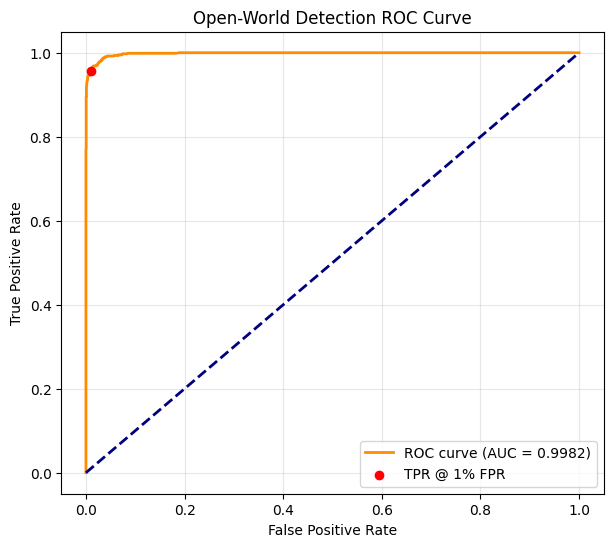

In [ ]:
from sklearn.metrics import auc # Add this import statement

print("=== [Phase 2] Open-World Binary Classification ===")

# 1. Data Merging (Monitored=1, Unmonitored=-1)
X_open = np.vstack([mon_features.values, unmon_features.values])
y_open = np.concatenate([np.ones(len(mon_features)), -1 * np.ones(len(unmon_features))])

# 2. Data Splitting
X_train_ow, X_test_ow, y_train_ow, y_test_ow = train_test_split(
    X_open, y_open, test_size=0.2, random_state=RANDOM_SEED, stratify=y_open
)

# 3. Model Training (Best Param + Class Weight Balanced)
# 'class_weight='balanced' is essential since there is more unmonitored data.
rf_open = RandomForestClassifier(
    **best_params_final,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_open.fit(X_train_ow, y_train_ow)

# 4. Evaluation
y_pred_ow = rf_open.predict(X_test_ow)
y_score_ow = rf_open.predict_proba(X_test_ow)[:, 1]

print(f" [Open-World Result]")
print(f"   - Precision: {precision_score(y_test_ow, y_pred_ow, pos_label=1):.4f}")
print(f"   - Recall:    {recall_score(y_test_ow, y_pred_ow, pos_label=1):.4f}")
print(f"   - F1-Score:  {f1_score(y_test_ow, y_pred_ow, pos_label=1):.4f}")

# 5. ROC Curve & Low FPR Analysis
fpr, tpr, _ = roc_curve(y_test_ow, y_score_ow, pos_label=1)
roc_auc = auc(fpr, tpr)

# Find 1% FPR point
target_fpr = 0.01
idx = np.abs(fpr - target_fpr).argmin()

print(f"   - ROC-AUC:   {roc_auc:.4f}")
print(f"   - TPR at 1% FPR: {tpr[idx]:.4f} (Detection Rate at Low False Positive Rate)")

# Plotting the graph
plt.figure(figsize=(7, 6))




plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[idx], tpr[idx], c='red', label=f'TPR @ 1% FPR', zorder=5)
plt.title('Open-World Detection ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 5. Open-World Experiment 2 (Multi-Class Classification)

**Scenario Setup & Metrics**

* Scenario Setup: Multi-class classification to identify the specific monitored site (0-94) or an unmonitored site (-1).

**Evaluation Metrics**:

* Accuracy: Classification accuracy across all 96 classes (95 Monitored + 1 Unmonitored).

* Accuracy (Monitored Only): Ratio of correctly predicting the exact site label among actual monitored traffic. Used to measure performance degradation against Closed-World accuracy.

* Top-3 Accuracy (Monitored Only): Probability that the correct answer is contained within the top 3 predicted candidates for actual monitored traffic.

**Evaluation Results**:

* Accuracy: 0.8533

* Accuracy (Monitored Only): 0.4789

* Top-3 Accuracy (Monitored Only): 0.7434

**Result Analysis**:

* The high Accuracy (0.8533) means the model is effectively filtering out the majority of unmonitored background data.

* Top-3 Accuracy remains high (0.7434), proving the model can effectively narrow the candidate pool even in a noisy open environment.


* *Data Preparation*

In [ ]:
print("=== [Phase 3] Open-World Multi-Class Classification Data Preparation ===")

# 1. Assign a label of -1 to all unmonitored features
y_unmon_multi = -1 * np.ones(len(unmon_features))

# 2. Concatenate the existing y_mon labels with the newly created -1 labels
y_open_multi = np.concatenate([y_mon, y_unmon_multi])

# 3. Stack the mon_features.values and unmon_features.values vertically
X_open_multi = np.vstack([mon_features.values, unmon_features.values])

# 4. Print diagnostic information
print(f"\nTotal samples in X_open_multi: {len(X_open_multi)}")
print(f"Shape of y_open_multi: {y_open_multi.shape}")
unique_labels, label_counts = np.unique(y_open_multi, return_counts=True)
print(f"Unique labels in y_open_multi: {unique_labels}")
print(f"Counts of unique labels: {label_counts}")

# 5. Split the combined data into training and testing sets
X_train_ow_multi, X_test_ow_multi, y_train_ow_multi, y_test_ow_multi = train_test_split(
    X_open_multi, y_open_multi, test_size=0.2, random_state=RANDOM_SEED, stratify=y_open_multi
)

# 6. Print the size of the training and testing sets
print(f"\nShape of X_train_ow_multi: {X_train_ow_multi.shape}")
print(f"Shape of y_train_ow_multi: {y_train_ow_multi.shape}")
print(f"Shape of X_test_ow_multi: {X_test_ow_multi.shape}")
print(f"Shape of y_test_ow_multi: {y_test_ow_multi.shape}")

# 7. Calculate and print the class distribution for the training set
print("\nClass distribution in y_train_ow_multi (training set):")
unique_train_labels, train_label_counts = np.unique(y_train_ow_multi, return_counts=True)
for label, count in zip(unique_train_labels, train_label_counts):
    print(f"  Label {int(label)}: {count} samples")

=== [Phase 3] Open-World Multi-Class Classification Data Preparation ===

Total samples in X_open_multi: 13800
Shape of y_open_multi: (13800,)
Unique labels in y_open_multi: [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18.]
Counts of unique labels: [10000   200   200   200   200   200   200   200   200   200   200   200
   200   200   200   200   200   200   200   200]

Shape of X_train_ow_multi: (11040, 19)
Shape of y_train_ow_multi: (11040,)
Shape of X_test_ow_multi: (2760, 19)
Shape of y_test_ow_multi: (2760,)

Class distribution in y_train_ow_multi (training set):
  Label -1: 8000 samples
  Label 0: 160 samples
  Label 1: 160 samples
  Label 2: 160 samples
  Label 3: 160 samples
  Label 4: 160 samples
  Label 5: 160 samples
  Label 6: 160 samples
  Label 7: 160 samples
  Label 8: 160 samples
  Label 9: 160 samples
  Label 10: 160 samples
  Label 11: 160 samples
  Label 12: 160 samples
  Label 13: 160 samples
  Label 14: 160 samples
  Label 15: 160 s


* *train*


In [ ]:
import json
from sklearn.ensemble import RandomForestClassifier

# Define RESULT_FILE path and RANDOM_SEED for robustness (assuming they are set globally elsewhere)
RESULT_FILE = "rf_tuning_result.json"
# RANDOM_SEED is already available in the kernel state from previous execution

# Load best_params_final from the JSON file
with open(RESULT_FILE, "r") as f:
    best_params_final = json.load(f)

print(f"Loaded best_params_final: {best_params_final}")

# 1. Instantiate RandomForestClassifier with best_params_final and required settings
rf_open_multi = RandomForestClassifier(
    **best_params_final,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# 2. Train the model using the prepared training data
print("\nTraining Open-World Multi-Class RandomForestClassifier...")
rf_open_multi.fit(X_train_ow_multi, y_train_ow_multi)

print("\nOpen-World Multi-Class RandomForestClassifier trained successfully.")

Loaded best_params_final: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}

Training Open-World Multi-Class RandomForestClassifier...

Open-World Multi-Class RandomForestClassifier trained successfully.



* *model evaluation*


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, top_k_accuracy_score, classification_report
import numpy as np

print("=== [Phase 3] Open-World Multi-Class Model Evaluation ===")

model_classes = rf_open_multi.classes_
y_pred = rf_open_multi.predict(X_test_ow_multi)
y_proba = rf_open_multi.predict_proba(X_test_ow_multi)
model_classes = rf_open_multi.classes_

acc = accuracy_score(y_test_ow_multi, y_pred)
f1 = f1_score(y_test_ow_multi, y_pred, average='weighted', zero_division=0)


monitored_mask = y_test_ow_multi != -1
y_test_monitored = y_test_ow_multi[monitored_mask]
y_pred_monitored = y_pred[monitored_mask]
y_proba_monitored = y_proba[monitored_mask]

if len(y_test_monitored) > 0:
    # (1) Accuracy (Monitored Only)
    acc_monitored = accuracy_score(y_test_monitored, y_pred_monitored)

    # (2) Top-3 Accuracy (Monitored Only)
    top3_acc = top_k_accuracy_score(
        y_test_monitored,
        y_proba_monitored,
        k=3,
        labels=model_classes
    )
else:
    acc_monitored = 0.0
    top3_acc = 0.0

top3_accuracy_all_classes = top_k_accuracy_score(
    y_test_ow_multi,
    y_proba,
    k=3,
    labels=model_classes
)

print(f"\n [Open-World Multi-class Result]")
print(f"   - Overall Accuracy (All Classes): {acc:.4f}")
print(f"   - Accuracy (Monitored Samples Only): {acc_monitored:.4f} ")
print("-" * 40)
print(f"   - Top-3 Accuracy (All classes): {top3_accuracy_all_classes:.4f}")
print(f"   - Top-3 Accuracy (Monitored Only): {top3_acc:.4f}")


=== [Phase 3] Open-World Multi-Class Model Evaluation ===

 [Open-World Multi-class Result]
   - Overall Accuracy (All Classes): 0.8533
   - Accuracy (Monitored Samples Only): 0.4789 
----------------------------------------
   - Top-3 Accuracy (All classes): 0.9286
   - Top-3 Accuracy (Monitored Only): 0.7434


# 6. Feature Importance Analaysis (Open-World)

**Top 5 Features**: n_total, n_in, cum_abs_sum, cum_final, cum_max_abs.

**Interpretation**:

* All top 5 features are Volume-based metrics (packet count or total data transferred).

* The model relies on the certainty of how much data was transferred as the primary evidence, over complex timing or burst patterns.

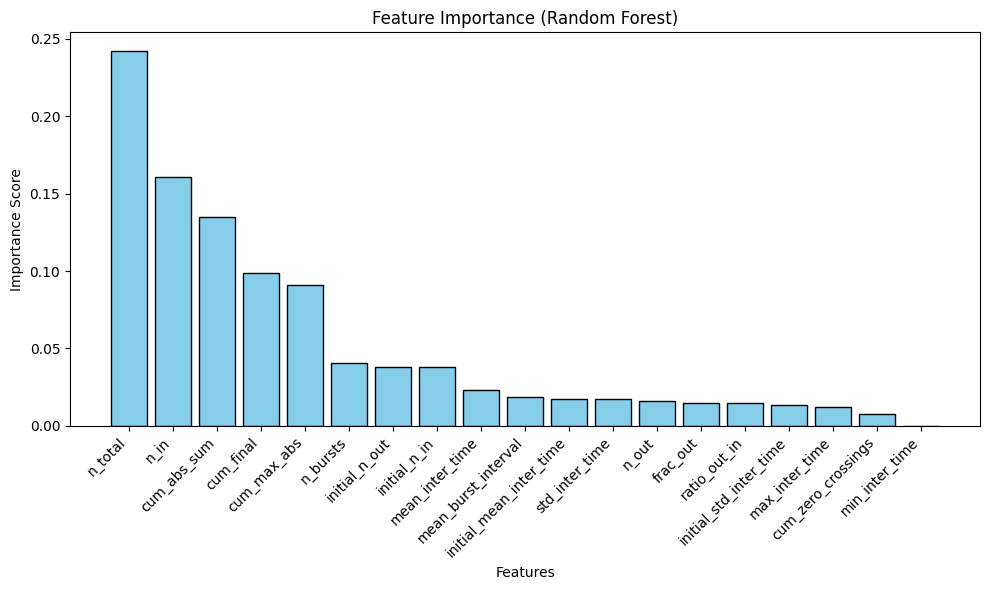

In [ ]:
# Visualize Feature Importance - open world
importances_ow = rf_open.feature_importances_


indices = np.argsort(importances_ow)[::-1]

plt.figure(figsize=(10, 6))

plt.title("Feature Importance (Random Forest)")
plt.bar(range(len(importances_ow)), importances_ow[indices], align="center", color='skyblue', edgecolor='black')
plt.xticks(range(len(importances_ow)), [FEATURE_NAMES[i] for i in indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
